# Human in the loop

The motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state

Compile the graph with `interrupt_before=["tools"]` where `tools` is our tools node.

In [2]:
from utils.LLM import model

In [5]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm_with_tools = model.bind_tools(tools)


from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


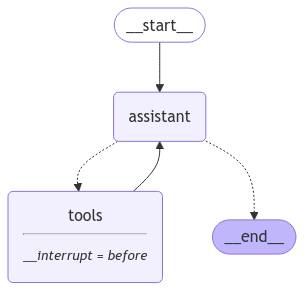

In [6]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0_53a8d37f-6c3a-4d76-b4a3-d3e2623c9551)
 Call ID: call_0_53a8d37f-6c3a-4d76-b4a3-d3e2623c9551
  Args:
    a: 2
    b: 3


## Continue invoke

We can get the current graph state for check

In [12]:
state = graph.get_state(thread)
print(state.next)
print(state)

('tools',)
StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='24899fe2-c87f-4728-9851-457dd8ee516b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_53a8d37f-6c3a-4d76-b4a3-d3e2623c9551', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 364, 'total_tokens': 389, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}, 'prompt_cache_hit_tokens': 256, 'prompt_cache_miss_tokens': 108}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4_prod', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-39df7b3b-5107-40db-85ef-41bdd957d581-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_0_53a8d37f-6c3a-4d76-b4a3-d3e2623c9551', 'type': 'tool_call'}], usage_metada

We can back to the graph just calling the graph with same thread again

```python
graph.stream(None, thread, stream_mode="values")
```

In [13]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_0_53a8d37f-6c3a-4d76-b4a3-d3e2623c9551)
 Call ID: call_0_53a8d37f-6c3a-4d76-b4a3-d3e2623c9551
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0_1baa17dc-b1d3-4179-8216-fce3b9f0748f)
 Call ID: call_0_1baa17dc-b1d3-4179-8216-fce3b9f0748f
  Args:
    a: 2
    b: 3


## Pass in API

As shown above, we can add `interrupt_before=["node"]` when compiling the graph that is running in Studio.

However, with the API, you can also pass `interrupt_before` to the stream method directly. 

In [14]:
from langgraph_sdk import get_client
client = get_client(url="http://localhost:56091")

initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

ConnectError: All connection attempts failed